## Домашнее задание

### Цель задания

1. Обучить простую модель семейства Mamba для обработки любых данных (на выбор: текст, аудио, видео, изображения и ...)
2. Визуализировать веса внимания и интерпретировать их
3. Сделать выводы о том, как модель воспринимает данные и принимает решения

### Решение

#### Импорты

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

from torchtext.datasets import AG_NEWS
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

import math
from einops import rearrange
from torch.autograd import Function

plt.style.use('ggplot')

#### Обработка датасета (классификация новостных текстов на 4 темы)

In [2]:
tokenizer = get_tokenizer('basic_english')
train_iter = AG_NEWS(split='train')

def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(train_iter),
                                specials=['<unk>', '<pad>'],
                                max_tokens=8000)
vocab.set_default_index(vocab['<unk>'])

pad_idx = vocab['<pad>']

def text_pipeline(text):
    tokens = tokenizer(text)
    return [vocab[token] for token in tokens]

def collate_batch(batch):
    label_list, text_list = [], []
    for (_label, _text) in batch:
        label_list.append(_label - 1)
        processed = torch.tensor(text_pipeline(_text), dtype=torch.long)
        text_list.append(processed)
    text_list = pad_sequence(text_list, batch_first=True, padding_value=pad_idx)
    return text_list, torch.tensor(label_list, dtype=torch.long)

batch_size = 32
train_dataset = AG_NEWS(split='train')
test_dataset = AG_NEWS(split='test')
trainloader = DataLoader(list(train_dataset), batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
testloader = DataLoader(list(test_dataset), batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
classes = ['World', 'Sports', 'Business', 'Sci/Tech']


#### Реализация Mamba (из семинара)

In [3]:
class PScan(Function):
    @staticmethod
    def forward(ctx, A_inp, X_inp):
        A, X = A_inp.clone(), X_inp.clone()
        A, X = rearrange(A, "l b d s -> b d l s"), rearrange(X, "l b d s -> b d l s")
        PScan._forward(A, X)
        ctx.save_for_backward(A.clone(), X)
        return rearrange(X, "b d l s -> b l d s")

    @staticmethod
    def backward(ctx, grad_inp):
        A, X = ctx.saved_tensors
        A = torch.cat((A[:, :, :1], A[:, :, 1:].flip(2)), dim=2)
        grad_out = rearrange(grad_inp, "b l d s -> b d l s")
        grad_out = grad_out.flip(2)
        PScan._forward(A, grad_out)
        grad_out = grad_out.flip(2)
        Q = torch.zeros_like(X)
        Q[:, :, 1:].add_(X[:, :, :-1] * grad_out[:, :, 1:])
        return rearrange(Q, "b d l s -> b l d s"), rearrange(grad_out, "b d l s -> b l d s")

    @staticmethod
    def _forward(A, X):
        b, d, l, s = A.shape
        num_steps = int(math.log2(l))
        Av, Xv = A, X
        for _ in range(num_steps):
            T = Xv.size(2)
            Av, Xv = Av[:, :, :T].reshape(b, d, T//2, 2, -1), Xv[:, :, :T].reshape(b, d, T//2, 2, -1)
            Xv[:, :, :, 1].add_(Av[:, :, :, 1].mul(Xv[:, :, :, 0]))
            Av[:, :, :, 1].mul_(Av[:, :, :, 0])
            Av, Xv = Av[:, :, :, 1], Xv[:, :, :, 1]
        for k in range(num_steps-1, -1, -1):
            Av, Xv = A[:, :, 2**k - 1 : l : 2**k], X[:, :, 2**k - 1 : l : 2**k]
            T = 2 * (Xv.size(2) // 2)
            if T < Xv.size(2):
                Xv[:, :, -1].add_(Av[:, :, -1].mul(Xv[:, :, -2]))
                Av[:, :, -1].mul_(Av[:, :, -2])
            Av, Xv = Av[:, :, :T].reshape(b, d, T//2, 2, -1), Xv[:, :, :T].reshape(b, d, T//2, 2, -1)
            Xv[:, :, 1:, 0].add_(Av[:, :, 1:, 0].mul(Xv[:, :, :-1, 1]))
            Av[:, :, 1:, 0].mul_(Av[:, :, :-1, 1])

pscan = PScan.apply

class RMSNorm(nn.Module):
    def __init__(self, d_model, eps=1e-8):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(d_model))

    def forward(self, x):
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps) * self.weight

class MambaBlock(nn.Module):
    def __init__(self, d_input, d_model):
        super().__init__()
        self.in_proj = nn.Linear(d_input, d_model)
        self.s_B = nn.Linear(d_model, d_model)
        self.s_C = nn.Linear(d_model, d_model)
        self.out_proj = nn.Linear(d_model, d_input)

    def forward(self, x):
        x = self.in_proj(x)
        B, C = self.s_B(x), self.s_C(x)
        return self.out_proj(x + B + C)

class Mamba(nn.Module):
    def __init__(self, num_layers, d_input, d_model):
        super().__init__()
        self.layers = nn.ModuleList([MambaBlock(d_input, d_model) for _ in range(num_layers)])
        
    def forward(self, seq):
        for block in self.layers:
            seq = block(seq)
        return seq


#### На основе Mamba сделаем классификатор

In [ ]:
class MambaClassifier(nn.Module):
    def __init__(self, vocab_size, d_input=256, d_model=128, num_layers=3, num_classes=4):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_input, padding_idx=pad_idx)
        self.mamba = Mamba(num_layers=num_layers, d_input=d_input, d_model=d_model)
        self.fc_out = nn.Linear(d_input, num_classes)
    def forward(self, x):
        x = self.embedding(x)
        x = self.mamba(x)
        x = x.mean(dim=1)
        return self.fc_out(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MambaClassifier(vocab_size=len(vocab), d_input=512, d_model=256, num_layers=6, num_classes=len(classes)).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


#### Запустим обучение

In [ ]:
def evaluate(model, loader):
    model.eval()
    total, correct = 0, 0
    with torch.no_grad():
        for texts, labels in loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            _, pred = outputs.max(1)
            total += labels.size(0)
            correct += (pred == labels).sum().item()
    return correct / total

train_loss, test_accuracy = [], []
for epoch in range(3):
    model.train()
    running_loss = 0.0
    for texts, labels in trainloader:
        texts, labels = texts.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(texts)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(trainloader)
    acc = evaluate(model, testloader)
    train_loss.append(avg_loss)
    test_accuracy.append(acc)
    print(f"Epoch {epoch + 1}: Loss={avg_loss:.4f}, Test Accuracy={acc:.4f}")

Epoch 1: Loss=18.6159, Test Accuracy=0.8211
Epoch 2: Loss=0.4121, Test Accuracy=0.8584
Epoch 3: Loss=0.3368, Test Accuracy=0.8820


Три эпохи, потому что если ставить больше - модель окончательно переобучается, а так, видим довольно неплохой тестовый accuracy

#### Функция визуализации эмбеддингов

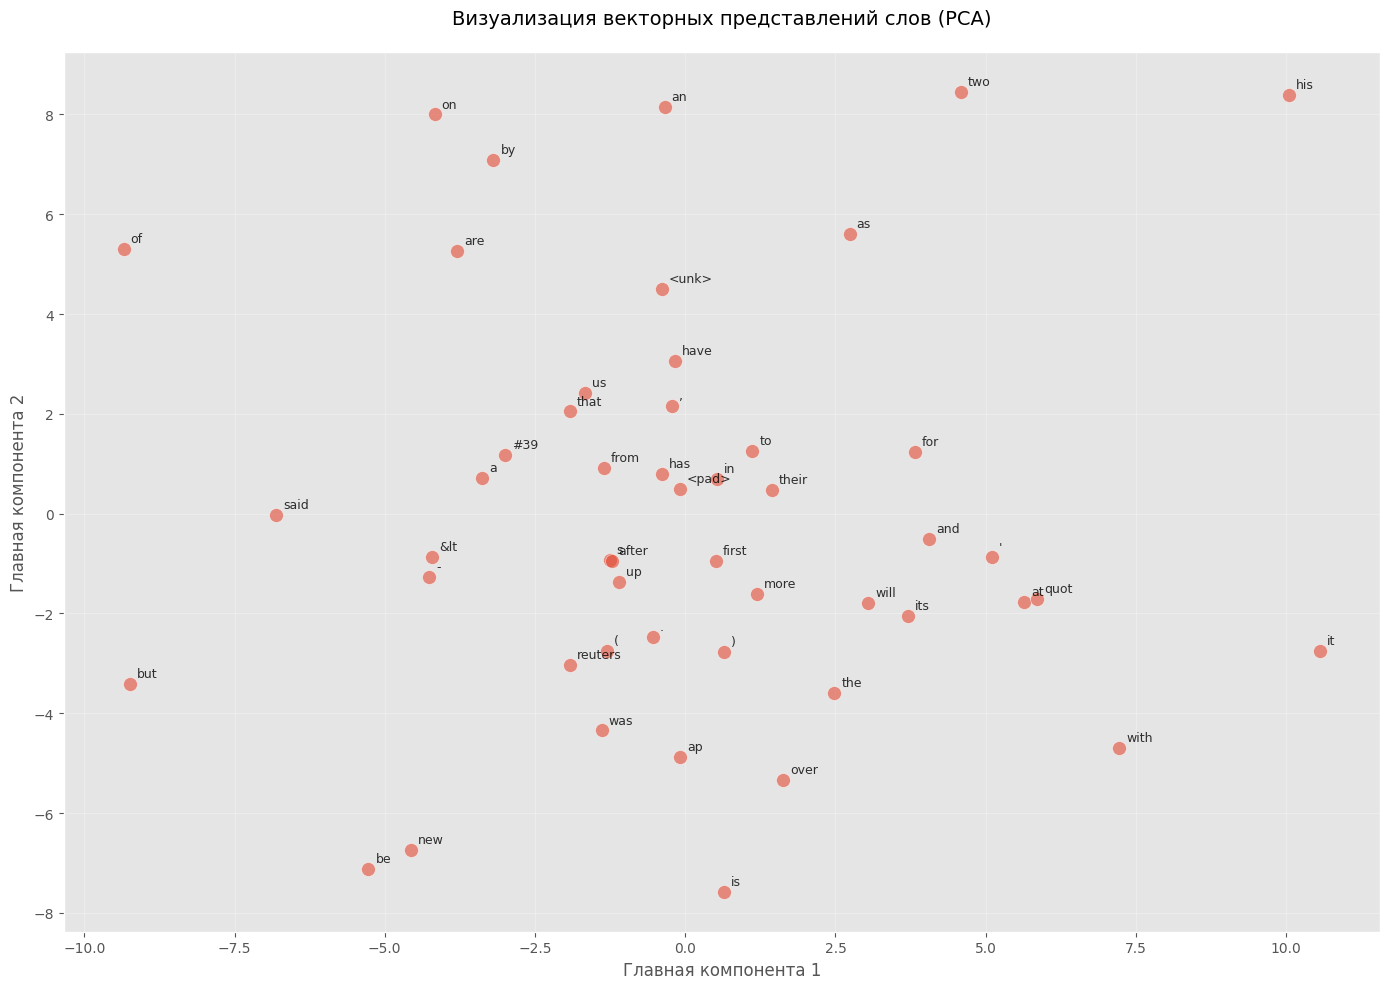

In [ ]:
def visualize_embeddings(model, words):
    embeddings = model.embedding.weight.data.cpu().numpy()
    
    # Уменьшаем размерность для визуализации
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(embeddings[:len(words)])
    
    plt.figure(figsize=(14, 10))
    plt.scatter(reduced[:, 0], reduced[:, 1], alpha=0.6, edgecolors='w', linewidth=0.5, s=100)
    
    for i, word in enumerate(words):
        plt.annotate(word, 
                    (reduced[i, 0], reduced[i, 1]),
                    textcoords="offset points",
                    xytext=(5,5),
                    ha='left',
                    fontsize=9,
                    alpha=0.8)
    
    plt.title("Визуализация векторных представлений слов (PCA)", fontsize=14, pad=20)
    plt.xlabel("Главная компонента 1", fontsize=12)
    plt.ylabel("Главная компонента 2", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


# Берем первые 50 слов, хотя можно смотреть любые слова
words = [vocab.get_itos()[i] for i in range(50)]
visualize_embeddings(model, words)

На самых популярных словах плохо видно, но даже на них понятно, что некотрые слова являются триггерами для одних нейронов, а некоторые - для других:
- "pad" - практически посередине, он никак не влияет
- "new" - ниже и левее
- "his", "two" - выше и правее, что может кардинально отличать итоговый текст от "new"

#### Визуализация активации нейронов на слоях
Функция визуализирует "внимание" - показывает то, на каких словах триггерятся конкретные нейроны

In [ ]:
def visualize_clean_heatmaps(model, sample_text, num_neurons=3):
    model.eval()
    tokens = text_pipeline(sample_text)
    tokenized_text = [vocab.get_itos()[t] for t in tokens]
    
    # Получаем активации
    input_tensor = torch.tensor(tokens, dtype=torch.long).unsqueeze(0).to(device)
    activations = []
    
    def hook_fn(module, input, output):
        activations.append(output.detach().cpu())
    
    hooks = [layer.register_forward_hook(hook_fn) for layer in model.mamba.layers]
    with torch.no_grad():
        _ = model(input_tensor)
    for hook in hooks:
        hook.remove()
    
    # Выбираем наиболее активные нейроны
    last_layer = activations[-1][0]
    top_neurons = last_layer.mean(dim=0).topk(num_neurons).indices
    
    plt.style.use('default')
    plt.rcParams['axes.facecolor'] = 'none'
    plt.rcParams['savefig.facecolor'] = 'none'
    
    fig = plt.figure(figsize=(14, 8), facecolor='none')
    
    # Тепловая карта
    for i, neuron_id in enumerate(top_neurons):
        ax = plt.subplot(2, num_neurons, i+1, facecolor='none')
        
        neuron_data = []
        for layer_act in activations:
            neuron_data.append(layer_act[0][:, neuron_id].numpy())
        neuron_data = np.array(neuron_data)
        
        im = ax.imshow(neuron_data, 
                      aspect='auto', 
                      cmap='coolwarm',
                      vmin=-2, 
                      vmax=2,
                      alpha=0.8)
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        
        ax.set_title(f"Нейрон {neuron_id.item()}", pad=10)
        ax.set_yticks(range(len(activations)))
        ax.set_yticklabels([f"Слой {i+1}" for i in range(len(activations))])
        ax.set_xticks([])
        
        cbar = plt.colorbar(im, ax=ax)
        cbar.outline.set_visible(False)
    
    # Линейные графики
    for i, neuron_id in enumerate(top_neurons):
        ax = plt.subplot(2, num_neurons, num_neurons+i+1, facecolor='none')
        
        neuron_data = []
        for layer_act in activations:
            neuron_data.append(layer_act[0][:, neuron_id].numpy())
        neuron_data = np.array(neuron_data)
        
        for layer_idx in range(neuron_data.shape[0]):
            ax.plot(neuron_data[layer_idx], 
                   label=f"Слой {layer_idx+1}",
                   alpha=0.8,
                   linewidth=2)
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_alpha(0.3)
        ax.spines['bottom'].set_alpha(0.3)
        
        ax.set_xticks(range(len(tokenized_text)))
        ax.set_xticklabels(tokenized_text, rotation=45, ha='right')
        ax.grid(axis='y', alpha=0.2, linestyle=':')
        ax.axhline(0, color='black', linewidth=0.5, alpha=0.3)
        
        if i == 0:
            ax.legend(frameon=False)
    
    plt.suptitle("Активации нейронов по слоям", y=1.02)
    plt.tight_layout()
    plt.show()

#### Визуализация важности токенов
Функция показывает то, на сколько важными были конкретные слова

In [ ]:
def visualize_token_importance(model, sample_text, vocab):
    model.eval()
    tokens = text_pipeline(sample_text)
    tokenized_text = [vocab.get_itos()[t] for t in tokens]
    
    # Базовый прогноз (оригинальный текст)
    base_input = torch.tensor(tokens, dtype=torch.long).unsqueeze(0).to(device)
    with torch.no_grad():
        base_output = model(base_input)
        base_prob = torch.softmax(base_output, dim=1)[0]
        pred_class = base_output.argmax().item()
    
    # Вычисляем важность каждого токена через "выпадение"
    importance_scores = []
    for i in range(len(tokens)):
        # Создаем модифицированную последовательность без i-го токена
        modified_tokens = tokens[:i] + tokens[i+1:]
        modified_input = torch.tensor(modified_tokens, dtype=torch.long).unsqueeze(0).to(device)
        
        with torch.no_grad():
            modified_output = model(modified_input)
            modified_prob = torch.softmax(modified_output, dim=1)[0, pred_class]
        
        # Важность = разница в вероятности целевого класса
        importance = (base_prob[pred_class] - modified_prob).item()
        importance_scores.append(importance)
    
    # Нормализуем важность
    importance_scores = np.array(importance_scores)
    importance_scores = (importance_scores - importance_scores.min()) / (importance_scores.max() - importance_scores.min() + 1e-8)
    
    plt.figure(figsize=(14, 6))
    colors = plt.cm.Reds(importance_scores)
    bars = plt.bar(range(len(importance_scores)), importance_scores, color=colors, edgecolor='grey', linewidth=0.7)
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom',
                fontsize=8)
    
    plt.title(f"Важность токенов для класса '{classes[pred_class]}'", fontsize=14, pad=20)
    plt.xlabel("Токены текста", fontsize=12)
    plt.ylabel("Относительная важность", fontsize=12)
    plt.xticks(range(len(tokenized_text)), tokenized_text, rotation=45, ha='right', fontsize=10)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"Анализ текста: '{sample_text}'\nКлассифицирован как: '{classes[pred_class]}'")
    print("Токены с наибольшей важностью:")
    for i in np.argsort(importance_scores)[-5:][::-1]:
        print(f"  '{tokenized_text[i]}': {importance_scores[i]:.3f}")

#### Визуализация решений модели
Функция показывает распределние вероятностей между классами

In [ ]:
def visualize_decision_making(model, sample_text, classes):
    model.eval()
    tokens = torch.tensor(text_pipeline(sample_text), dtype=torch.long).unsqueeze(0).to(device)
    
    with torch.no_grad():
        embeddings = model.embedding(tokens)
        mamba_output = model.mamba(embeddings)
        logits = model.fc_out(mamba_output.mean(dim=1))
        probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
    
    colors = plt.cm.Blues(np.linspace(0.3, 1, len(classes)))
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(classes, probs, color=colors, edgecolor='black', linewidth=0.7)
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom',
                fontsize=12)
    
    plt.title("Вероятности принадлежности к классам", fontsize=14, pad=20)
    plt.xlabel("Классы", fontsize=12)
    plt.ylabel("Вероятность", fontsize=12)
    plt.ylim(0, 1.1)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    pred_class = classes[np.argmax(probs)]
    pred_prob = np.max(probs)
    print(f"Прогноз модели: '{sample_text}'\nОтносится к классу '{pred_class}' с вероятностью {pred_prob:.2%}")

#### Визуализация на конкретных примерах

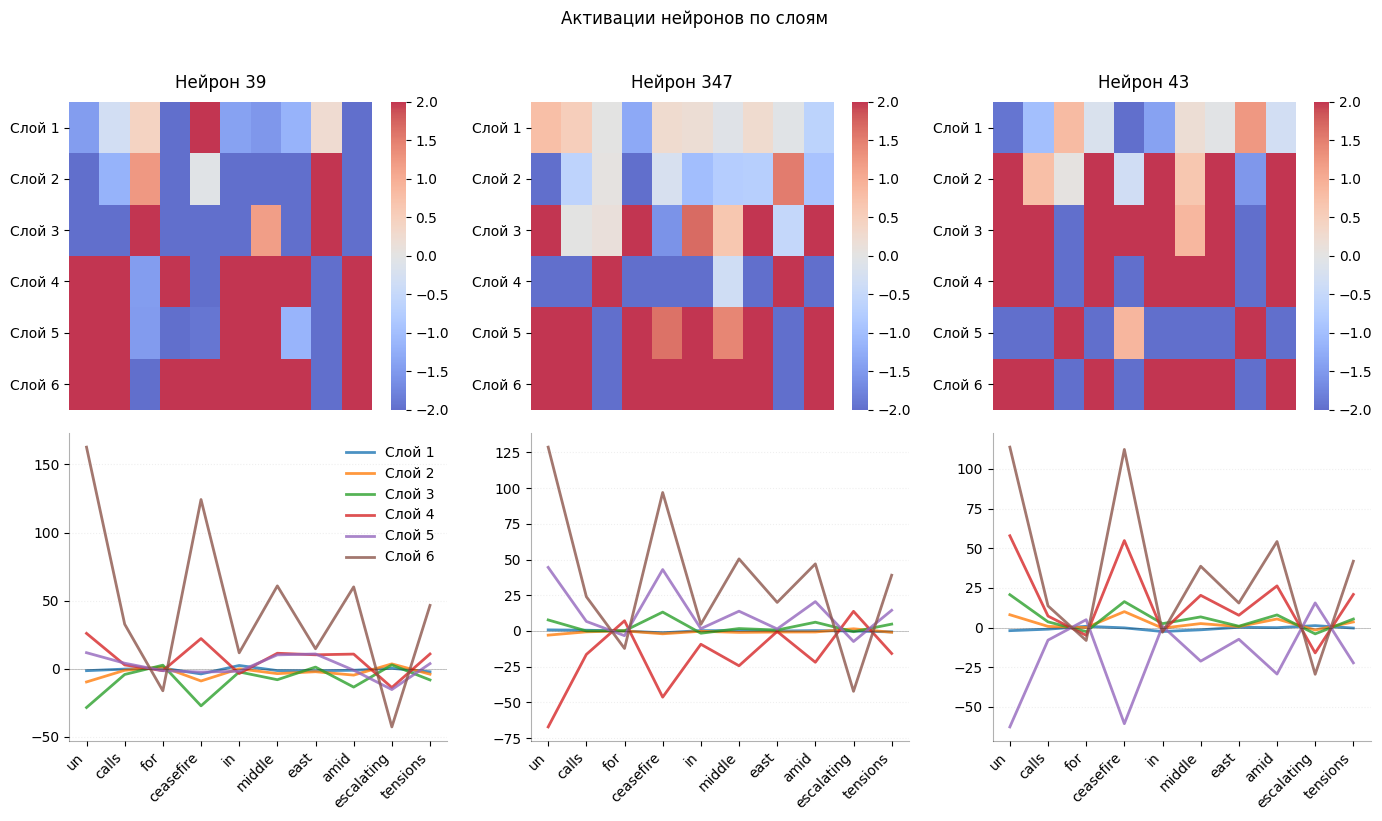

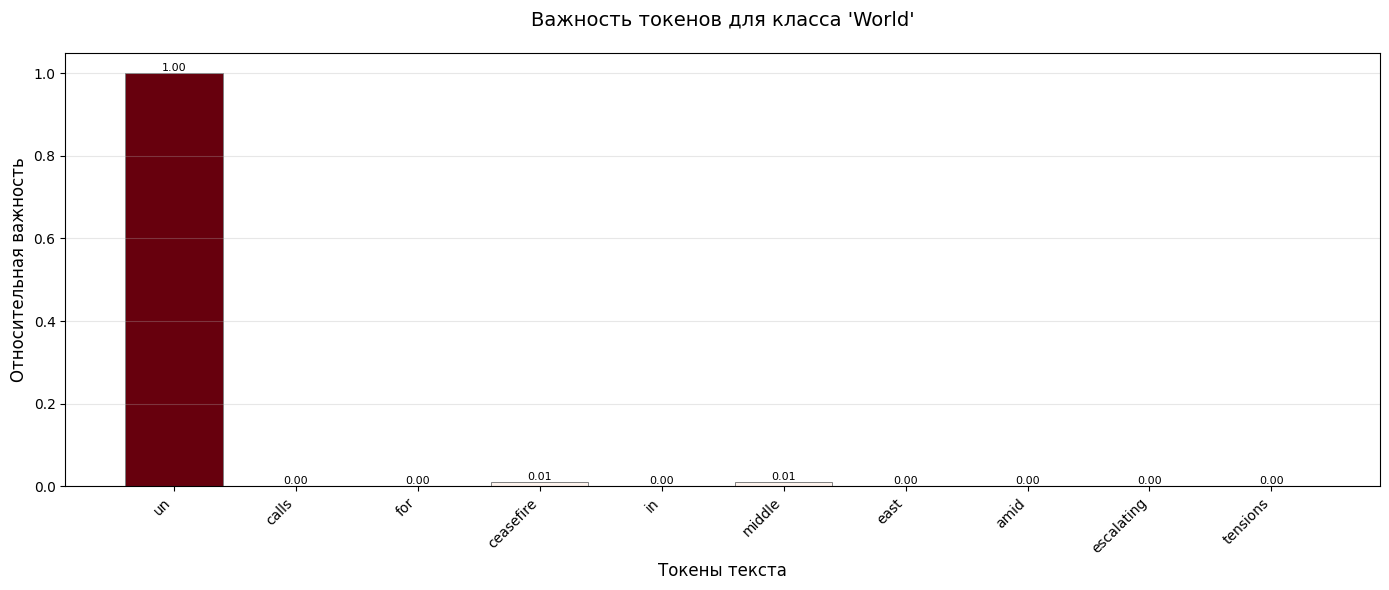

Анализ текста: 'UN calls for ceasefire in Middle East amid escalating tensions'
Классифицирован как: 'World'
Токены с наибольшей важностью:
  'un': 0.999
  'middle': 0.010
  'ceasefire': 0.010
  'tensions': 0.000
  'escalating': 0.000


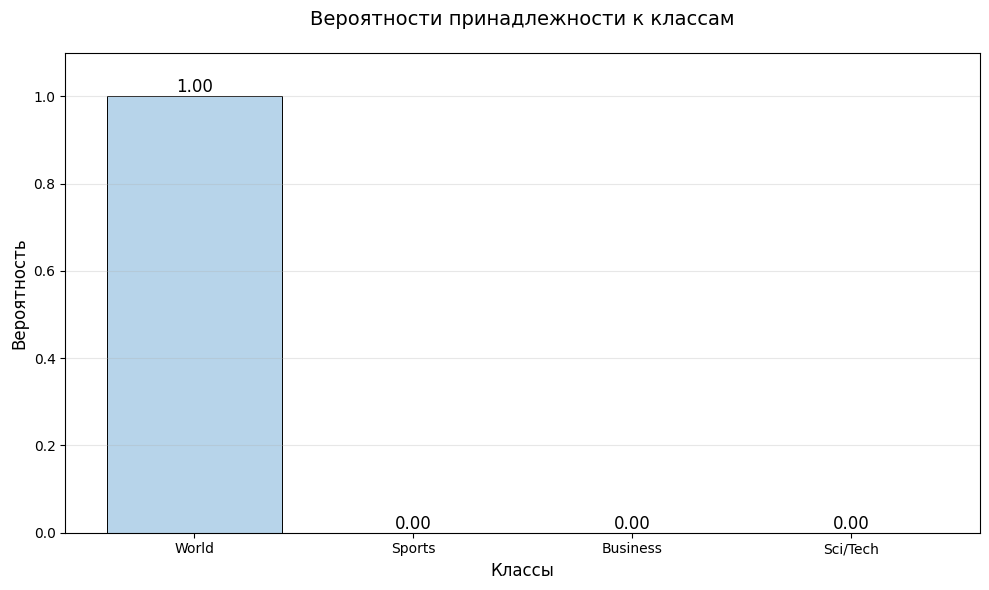

Прогноз модели: 'UN calls for ceasefire in Middle East amid escalating tensions'
Относится к классу 'World' с вероятностью 100.00%


In [ ]:
sample_text = "UN calls for ceasefire in Middle East amid escalating tensions"

visualize_clean_heatmaps(model, sample_text, num_neurons=3)
visualize_token_importance(model, sample_text, vocab)
visualize_decision_making(model, sample_text, classes)

Текст для категории "World" отлично классифицировался - триггерным словом было слово "UN", больше всех активировались слои 5 и 6

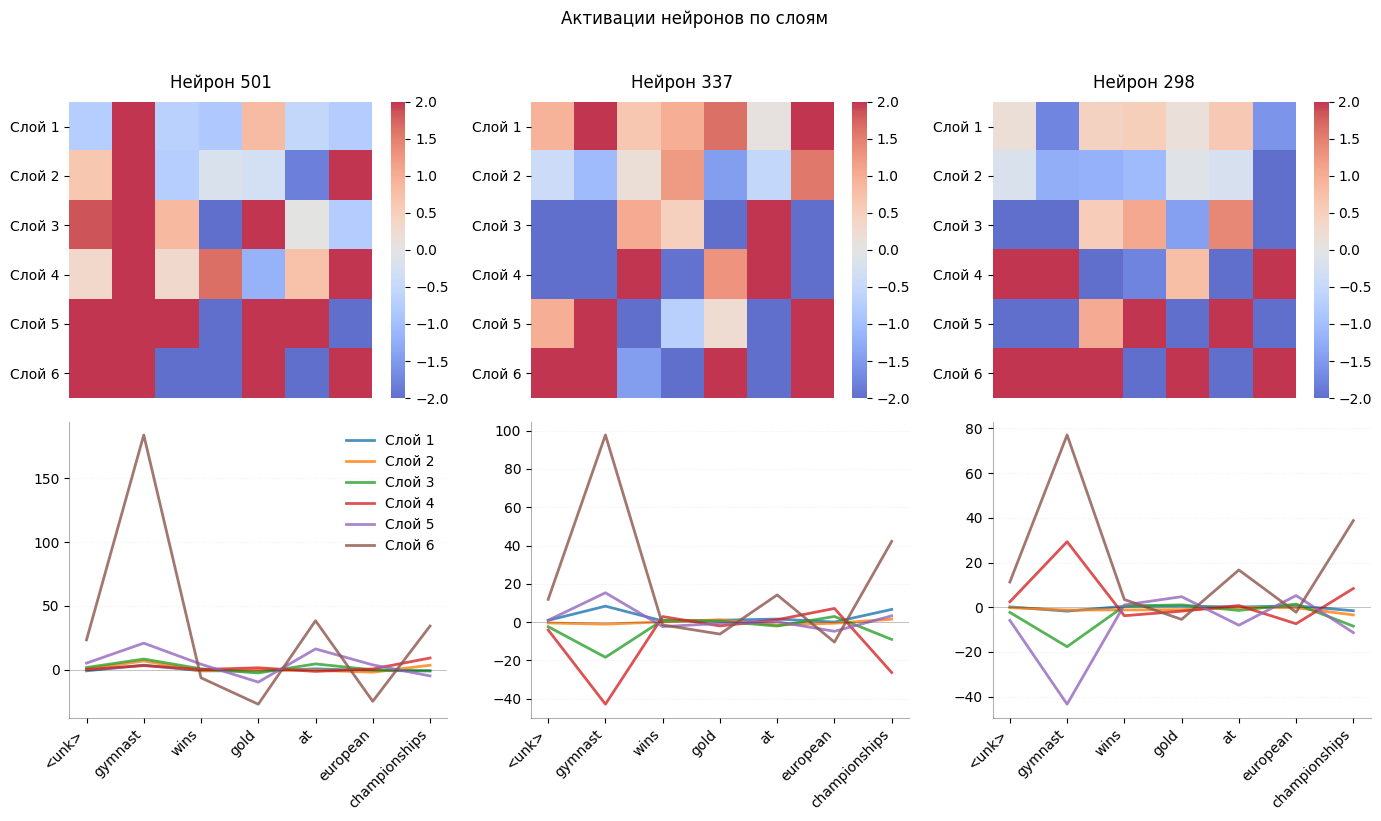

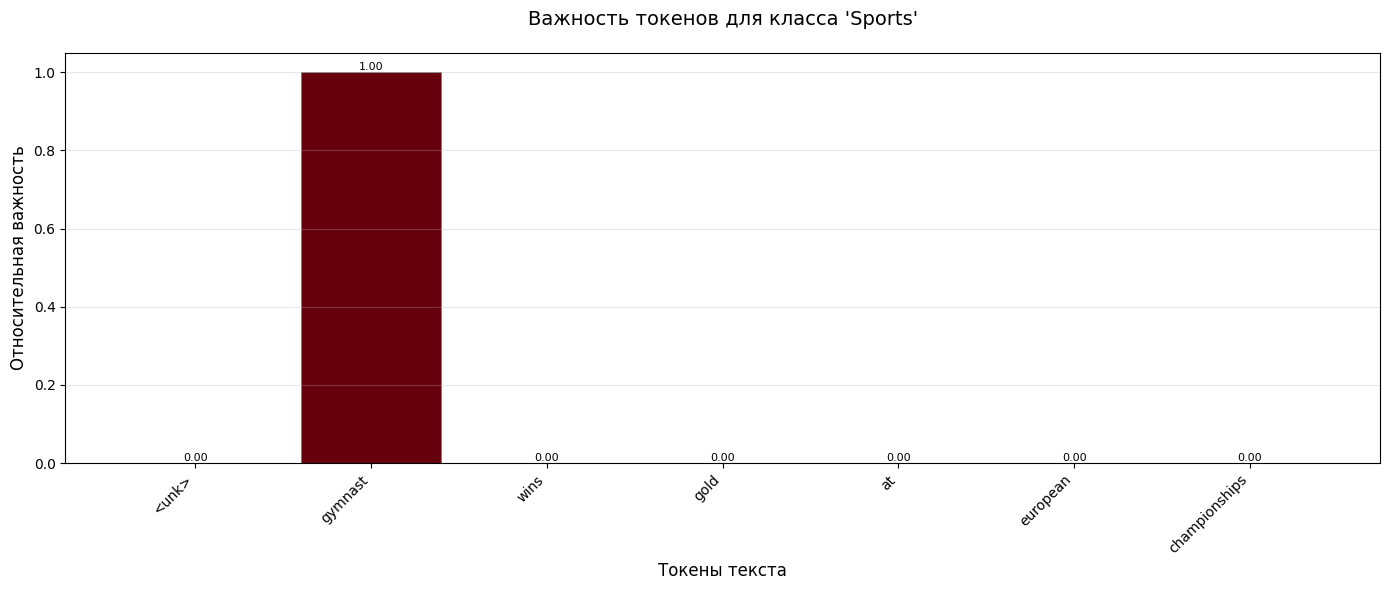

Анализ текста: 'WimYoung gymnast wins gold at European Championships'
Классифицирован как: 'Sports'
Токены с наибольшей важностью:
  'gymnast': 1.000
  'european': 0.000
  'championships': 0.000
  'at': 0.000
  'gold': 0.000


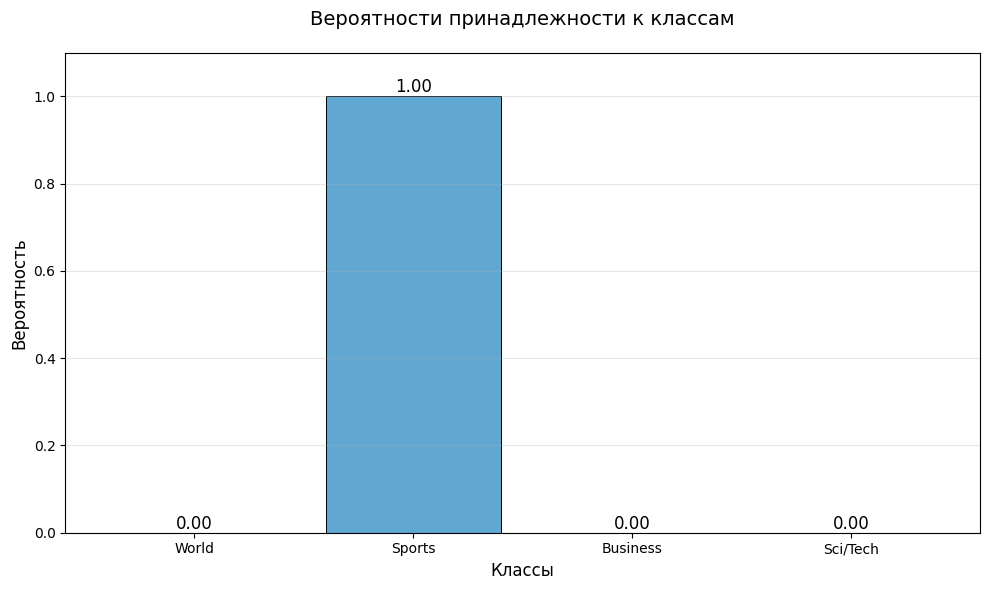

Прогноз модели: 'WimYoung gymnast wins gold at European Championships'
Относится к классу 'Sports' с вероятностью 100.00%


In [ ]:
sample_text = "WimYoung gymnast wins gold at European Championships"

visualize_clean_heatmaps(model, sample_text, num_neurons=3)
visualize_token_importance(model, sample_text, vocab)
visualize_decision_making(model, sample_text, classes)

Текст для категории "Sport" отлично классифицировался - триггерным словом было слово "gymnast", что очевидно. Больше всех активировался слой 6

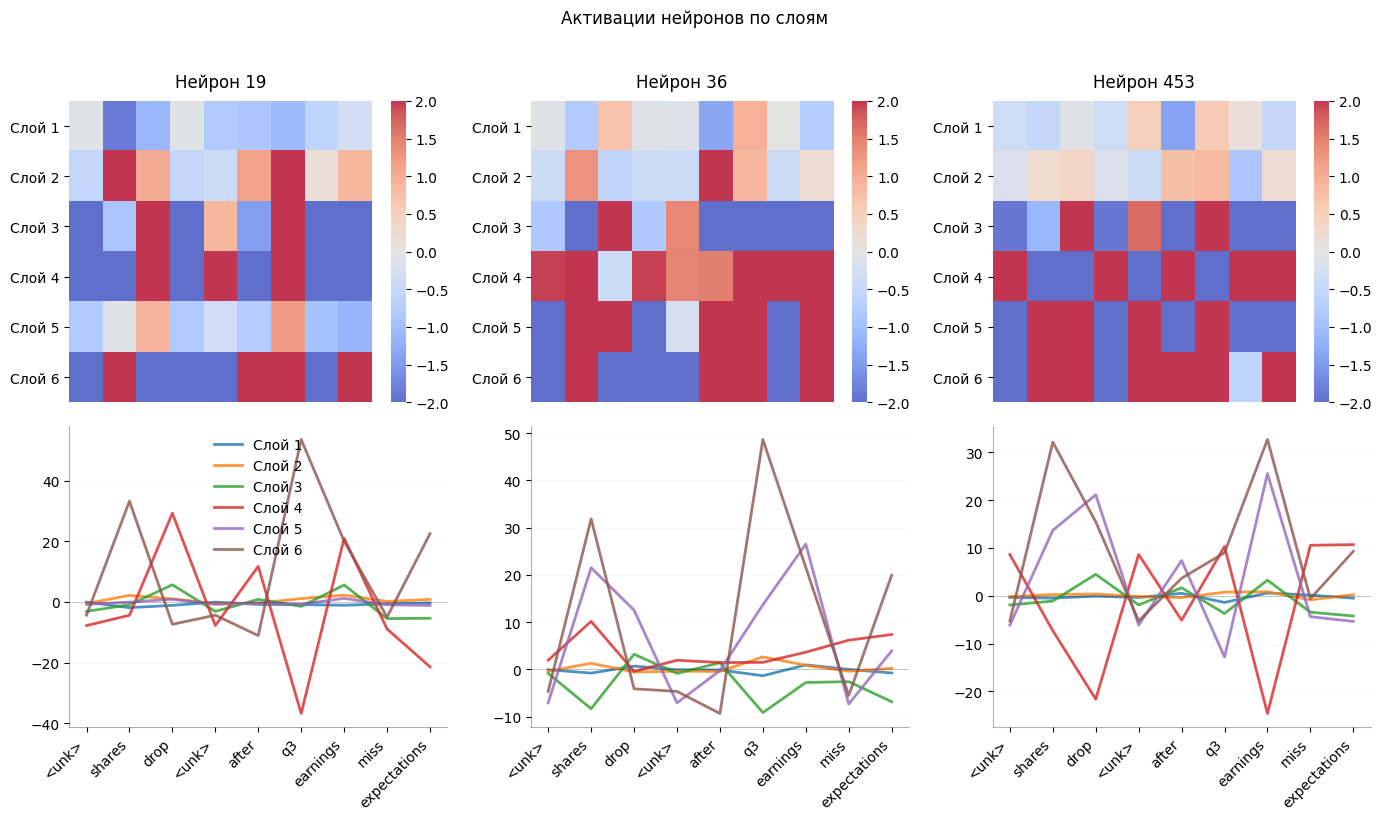

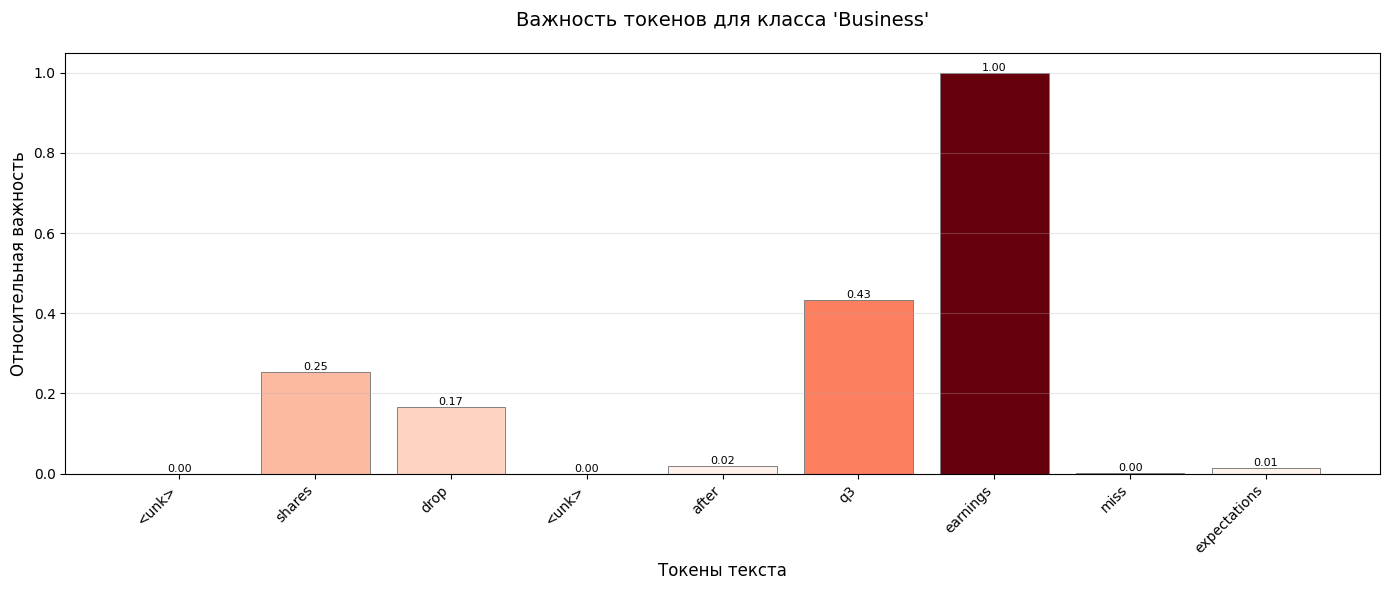

Анализ текста: 'Tesla shares drop 5% after Q3 earnings miss expectations'
Классифицирован как: 'Business'
Токены с наибольшей важностью:
  'earnings': 1.000
  'q3': 0.434
  'shares': 0.253
  'drop': 0.167
  'after': 0.019


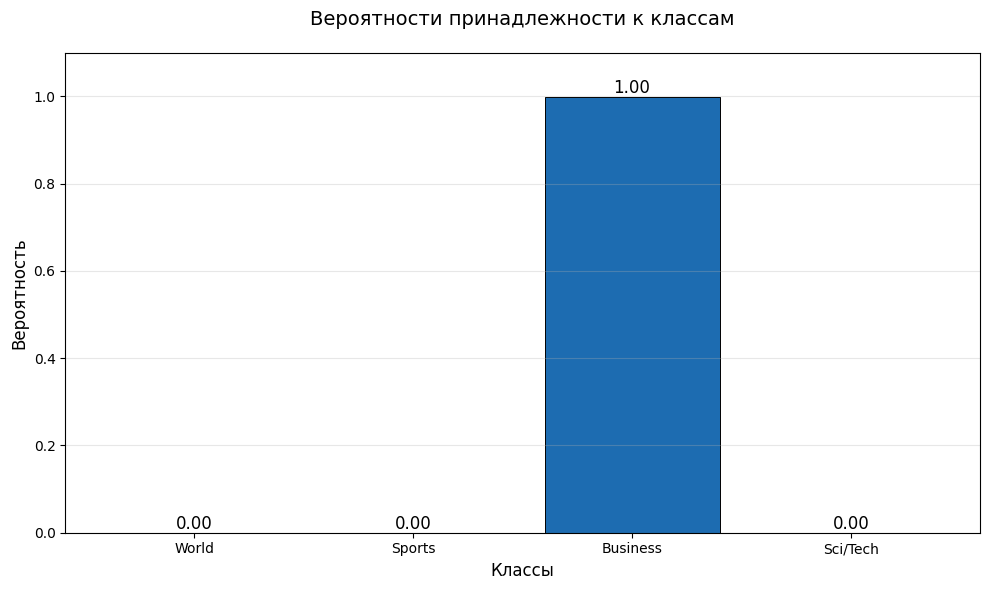

Прогноз модели: 'Tesla shares drop 5% after Q3 earnings miss expectations'
Относится к классу 'Business' с вероятностью 99.95%


In [ ]:
sample_text = "Tesla shares drop 5% after Q3 earnings miss expectations"

visualize_clean_heatmaps(model, sample_text, num_neurons=3)
visualize_token_importance(model, sample_text, vocab)
visualize_decision_making(model, sample_text, classes)

Текст для категории "Buisness" тоже хорошо классифицировался - одно триггерное слово выделить нельзя, их было несколько. Видно, что на трех из шести слоях нейроны сильно активировались. Возможно это значит, что модель фиксировала зависимость между слоями

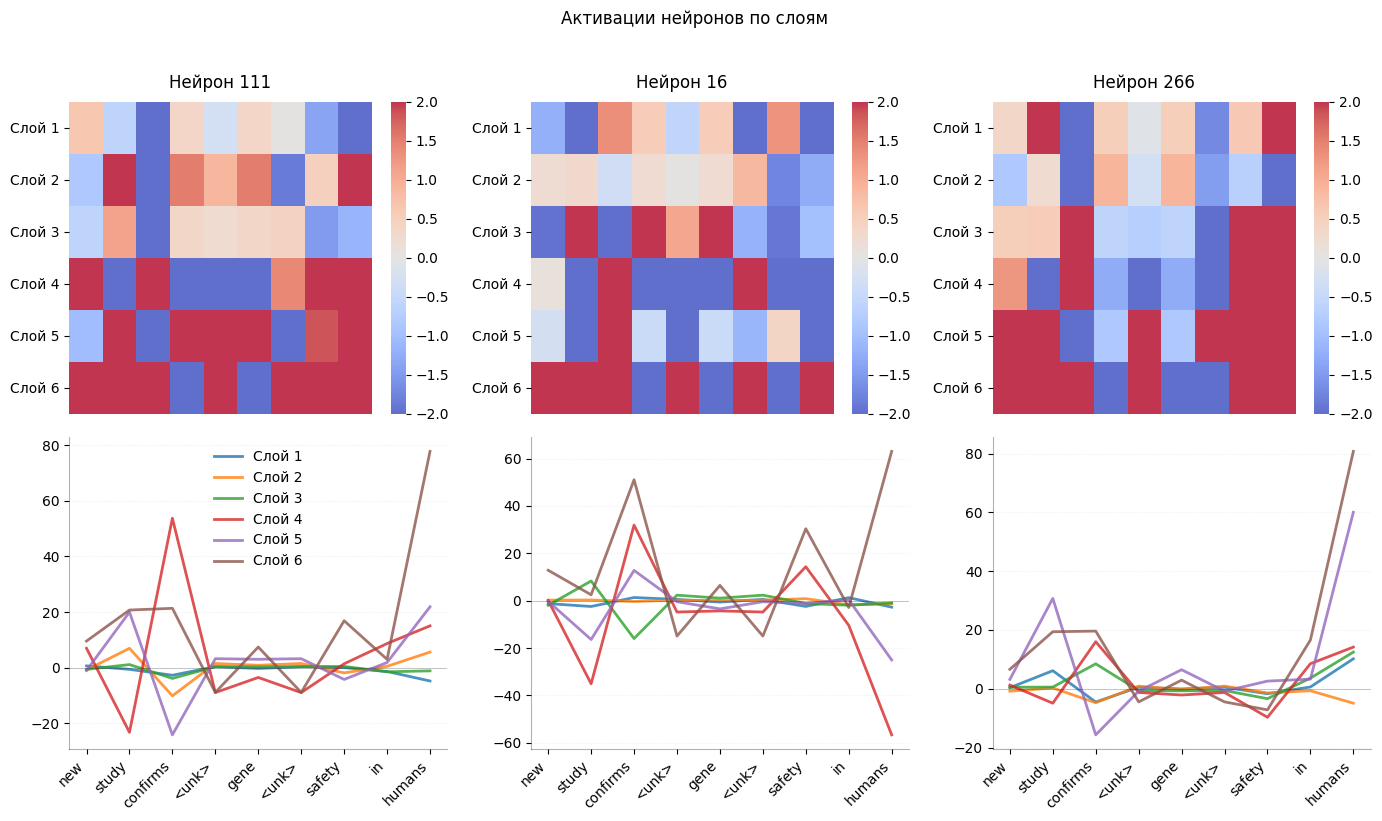

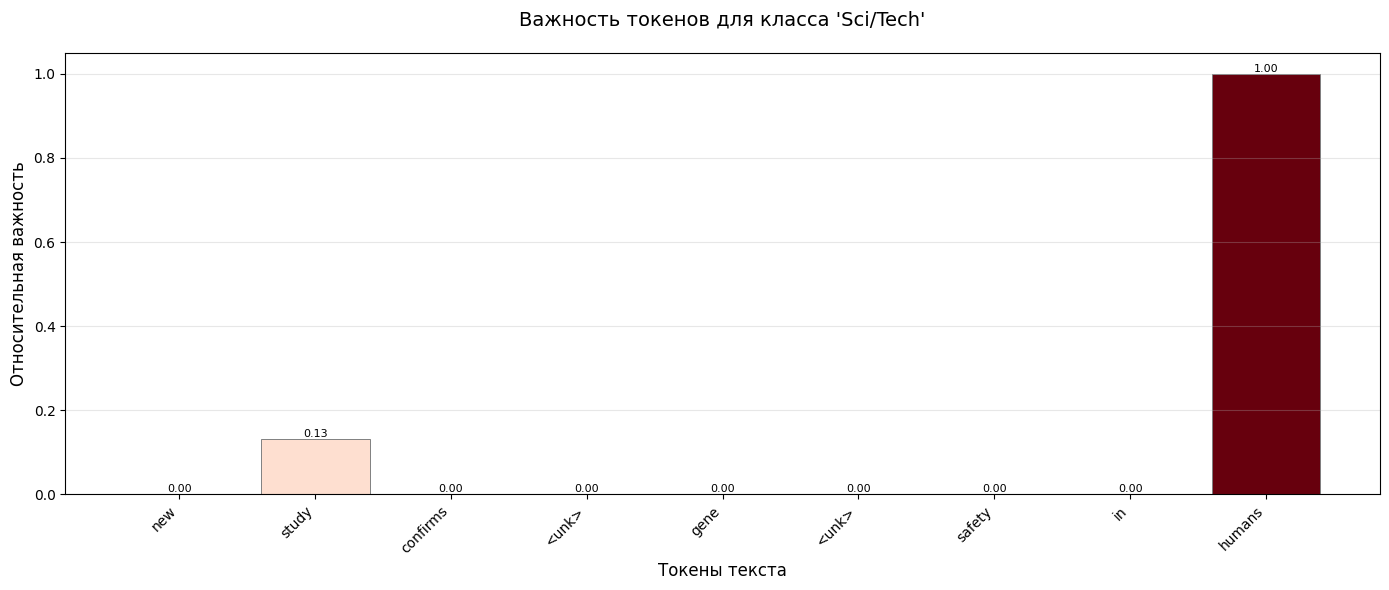

Анализ текста: 'New study confirms CRISPR gene editing safety in humans'
Классифицирован как: 'Sci/Tech'
Токены с наибольшей важностью:
  'humans': 1.000
  'study': 0.131
  'in': 0.002
  '<unk>': 0.001
  '<unk>': 0.001


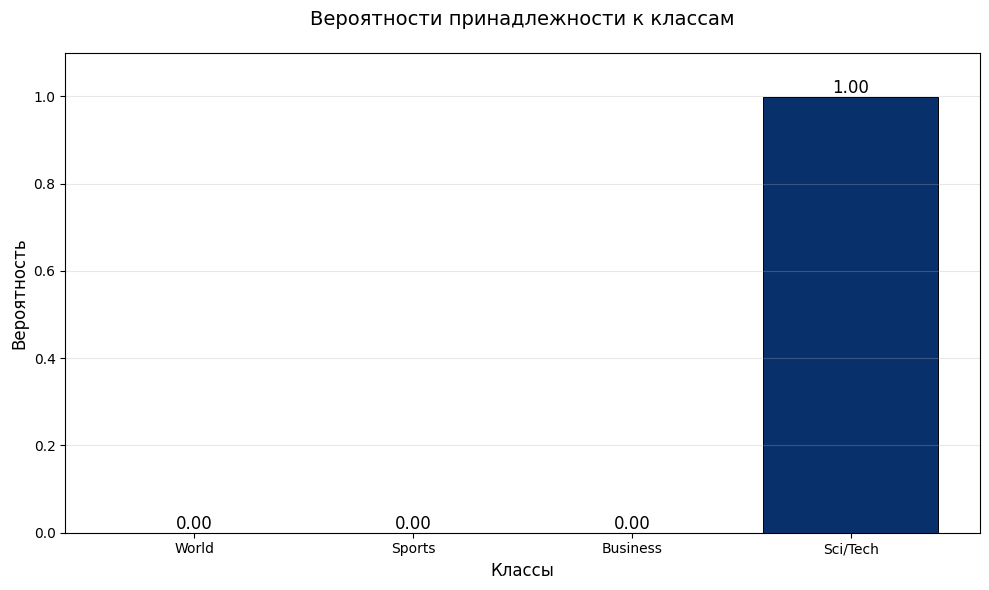

Прогноз модели: 'New study confirms CRISPR gene editing safety in humans'
Относится к классу 'Sci/Tech' с вероятностью 99.97%


In [ ]:
sample_text = "New study confirms CRISPR gene editing safety in humans"

visualize_clean_heatmaps(model, sample_text, num_neurons=3)
visualize_token_importance(model, sample_text, vocab)
visualize_decision_making(model, sample_text, classes)

Текст для категории "Sci/Tech" тоже отлично классифицировался - триггерами выступили "humans" и "study". Видно, что на некоторых слоях активировались одни слои, а на других - другие! Это интересное наблюдение значит, что разные слои отвечают за разные классы и токены

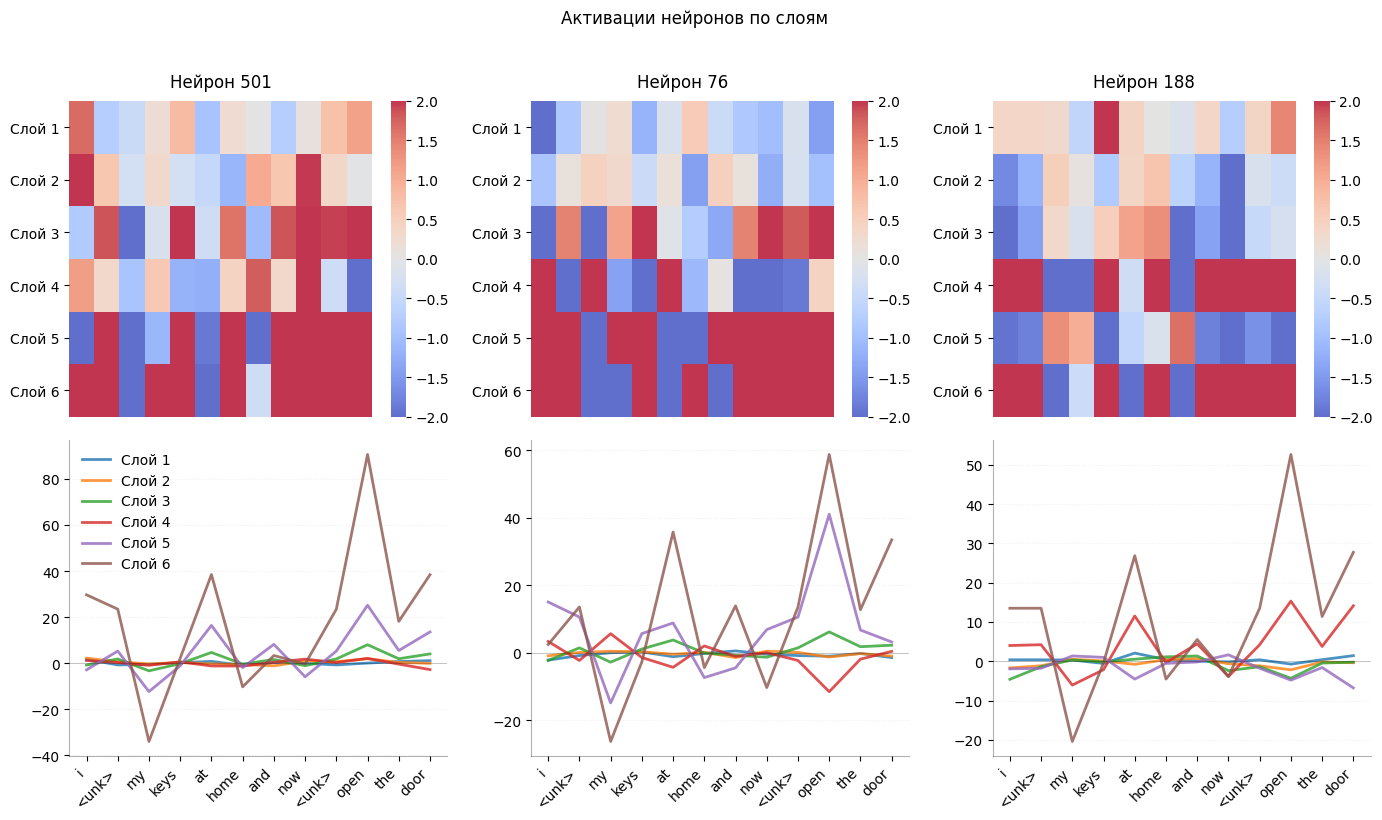

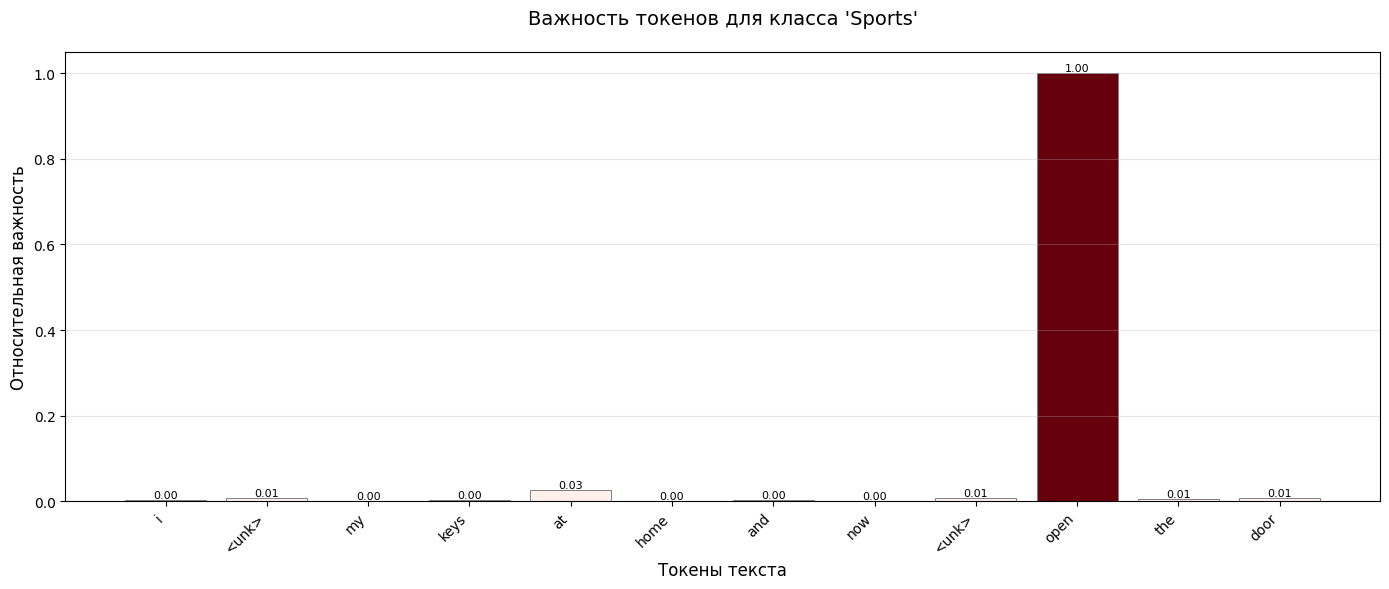

Анализ текста: 'I forgot my keys at home and now can’t open the door'
Классифицирован как: 'Sports'
Токены с наибольшей важностью:
  'open': 1.000
  'at': 0.026
  'door': 0.008
  '<unk>': 0.008
  '<unk>': 0.008


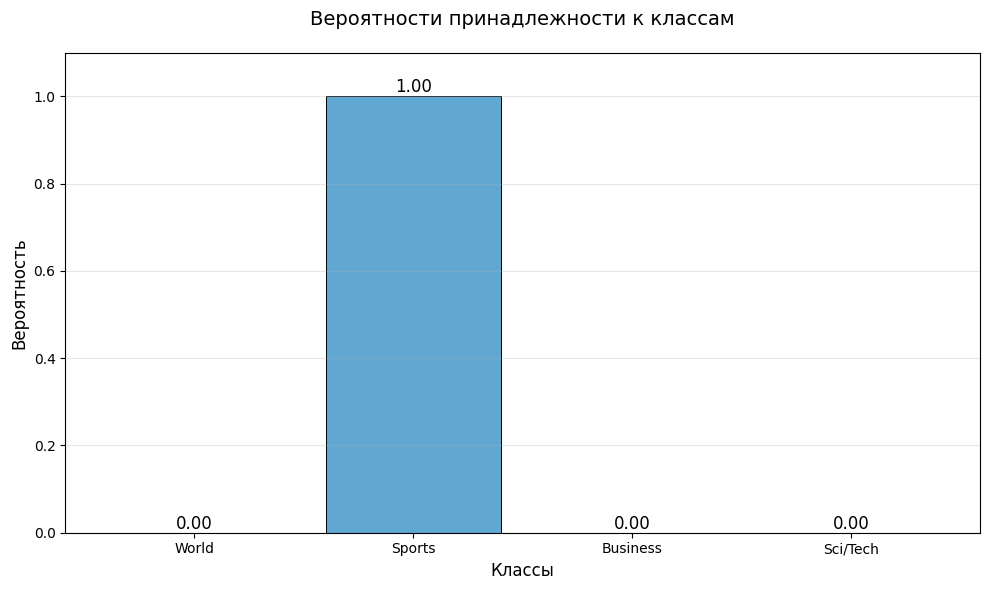

Прогноз модели: 'I forgot my keys at home and now can’t open the door'
Относится к классу 'Sports' с вероятностью 100.00%


In [ ]:
sample_text = "I forgot my keys at home and now can’t open the door"

visualize_clean_heatmaps(model, sample_text, num_neurons=3)
visualize_token_importance(model, sample_text, vocab)
visualize_decision_making(model, sample_text, classes)

К сожалению текст, который не принадлежит ни к одной из категорий однозначно классифицировался в "Sport" - это говорит о переобучении и слабости архитектуры.

#### Графики лосса и точности

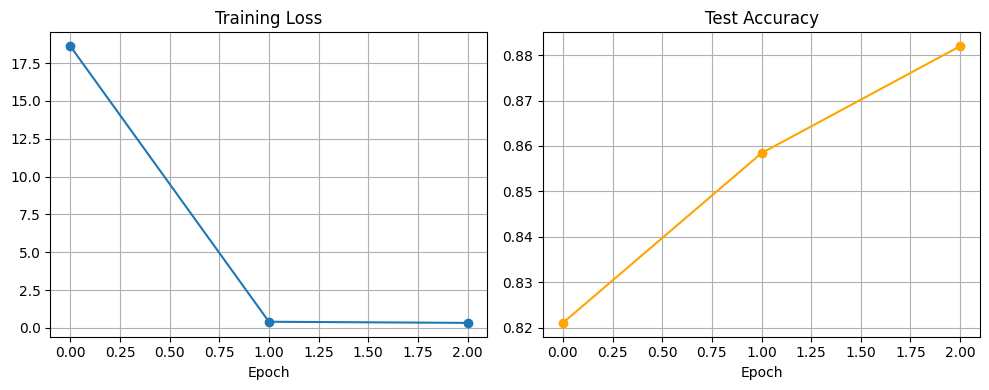

In [15]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss, marker='o')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(test_accuracy, marker='o', color='orange')
plt.title("Test Accuracy")
plt.xlabel("Epoch")
plt.grid(True)
plt.tight_layout()
plt.show()


Взглянув на график лосса, гипотеза подтверждается - нулевой лосс на трейне свидетельсвует о переобучении.

Несмотря на это мы получили неплохую модель, способную предсказывать класс новостей!